In [4]:
print('X'*30 + '_Loading and Parsing data_' + 'X'*30)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Loading and Parsing data_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [3]:
#Loading and Parsing data
%run data_r.ipynb

train_image_folder = "/datasets/ee285f-public/PascalVOC2012/JPEGImages/"
train_annot_folder = "/datasets/ee285f-public/PascalVOC2012/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height


LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']


BATCH_SIZE        = 200
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
CLASS             = len(LABELS)


generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}




train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)

def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

In [5]:
print('X'*30 + '_Defining YOLOv2_' + 'X'*30)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Defining YOLOv2_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [6]:
#Define YOLOv2
%run model_r.ipynb
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
maxpool1_4

In [9]:
print('X'*30 + '_Setting YOLOv2 Param_' + 'X'*30)
print('X'*30 + '_Either choose::1 _Weights_yolo_on_voc2012.h5' + 'X'*30)
print('X'*30 + '_Or     choose::2 _yolov2.weights ' + 'X'*30)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Setting YOLOv2 Param_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Either choose::1 _weights_yolo_on_voc2012.h5XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Or     choose::2 _yolov2.weights XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [73]:
#set pre trained weights
%run weight_r.ipynb
# path_to_weight = "./yolov2.weights"
# path_to_weight = './Weights_yolo_on_voc2012.h5'
# path_to_weight = 'weights_yumi.h5'
path_to_weight = './Weights_yolo_on_voc2012.h5'



nb_conv        = 22
model          = set_pretrained_weight(model,nb_conv, path_to_weight)



In [67]:
%run weight_r.ipynb
layer          = model.layers[-4] # the last convolutional layer
initialize_weight(layer,sd=1/(GRID_H*GRID_W)) # does this change the model ? 



In [68]:
print('X'*30 + '_Setting Custom Loss_' + 'X'*30)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Setting Custom Loss_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [74]:
#Define Custom Loss Funciton 
%run loss_r.ipynb
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0
def custom_loss(y_true, y_pred):
    return(custom_loss_core(
                     y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT))



In [75]:
print('X'*30 + '_Setting YOLOv2 Experiment for training_' + 'X'*30)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Setting YOLOv2 Experiment for training_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [76]:
#Set up experiment
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop
from keras import backend as K

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


BATCH_SIZE   = 32
generator_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('Weights_yolo_on_voc2012.h5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)


optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(loss=custom_loss, optimizer=optimizer)

In [77]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
# checkpoint_path = './weights_yolo_on_voc2012.h5'
# model.load_weights(checkpoint_path)

model.fit_generator(generator        = train_batch_generator, 
                steps_per_epoch  = len(train_batch_generator), 
                epochs           = 50, 
                verbose          = 1,
                #validation_data  = valid_batch,
                #validation_steps = len(valid_batch),
                callbacks        = [early_stop, checkpoint], 
                max_queue_size   = 3)

Epoch 1/50


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 92/536 [====>.........................] - ETA: 3:45 - loss: nan

KeyboardInterrupt: 

In [57]:
print('X'*30 + '_Loads Wieghts For testing YOLOv2 Param_' + 'X'*30)
print('X'*30 + '_Skip if already loaded YOLOv2 Param_' + 'X'*30)


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Loads Wieghts For testing YOLOv2 Param_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_Skip if already loaded YOLOv2 Param_XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [78]:
%run data_r.ipynb # for loading ImageReader
path_to_weight = './Weights_yolo_on_voc2012.h5'
# path_to_weight = './weights_yumi.h5'
model.load_weights(path_to_weight)


IMAGE_H, IMAGE_W  = 416, 416
imageReader = ImageReader(IMAGE_H=IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
# out = imageReader.fit(train_image_folder + "/2007_005430.jpg")
out = imageReader.fit(train_image_folder + "/2007_005450.jpg")
out = imageReader.fit(train_image_folder + "/2007_005688.jpg")
X_test = np.expand_dims(out,0)
# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])
# print(y_pred)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [79]:
%run output_r.ipynb # find output boxes  and other stuff

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

netout         = y_pred[0]

outputRescaler = OutputRescaler(ANCHORS=ANCHORS)

netout_scale   = outputRescaler.fit(netout)

obj_threshold  = 0.015
pred_low_tsh   = find_high_class_probability_bbox(netout_scale,obj_threshold)

obj_threshold  = 0.03
pred_high_tsh  = find_high_class_probability_bbox(netout_scale,obj_threshold)




In [80]:
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.015
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 85 bounding boxes with top class probability > 0.015

obj_threshold=0.03
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 57 bounding boxes with top class probability > 0.03


Plot with low object threshold
chair      0.016 xmin=  19,ymin=   8,xmax= 336,ymax= 295
sofa       0.023 xmin=  36,ymin=   5,xmax= 378,ymax= 301
cat        0.022 xmin= 106,ymin=  43,xmax= 305,ymax= 263
sofa       0.024 xmin=  74,ymin=   0,xmax= 393,ymax= 317
cat        0.021 xmin= 126,ymin=  41,xmax= 352,ymax= 268
cat        0.017 xmin= 197,ymin=  37,xmax= 399,ymax= 271
chair      0.017 xmin=   0,ymin=   8,xmax= 205,ymax= 355
cat        0.022 xmin=   0,ymin=  58,xmax= 138,ymax= 303


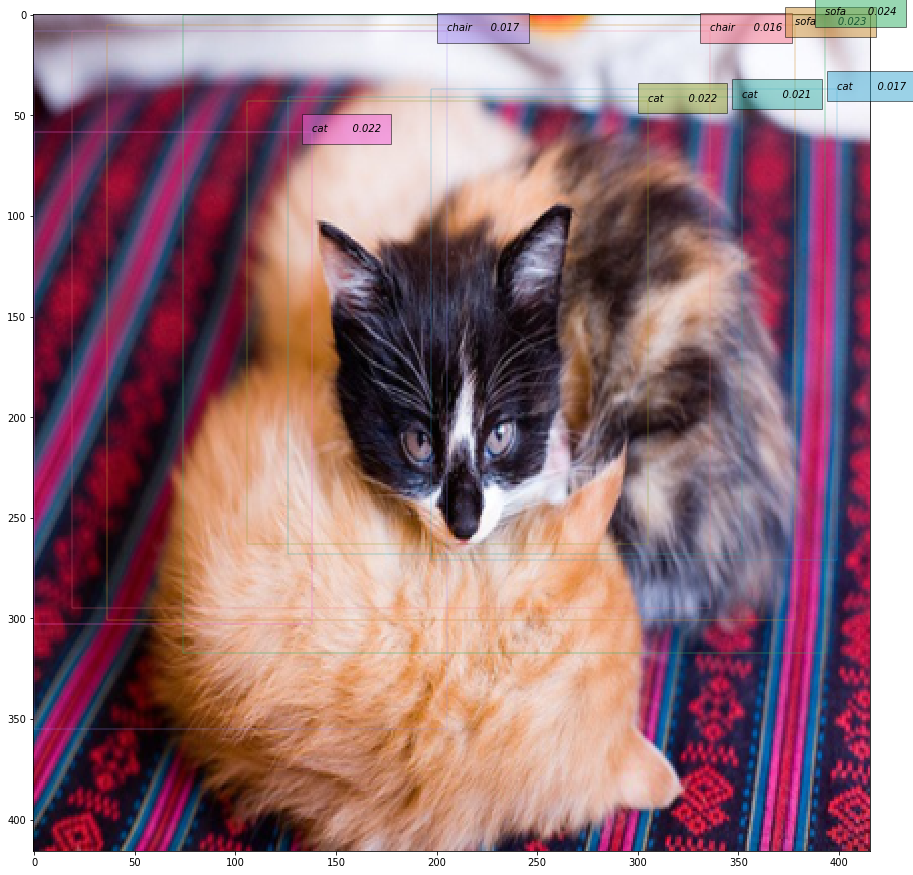

Plot with high object threshold
cat        0.037 xmin=  34,ymin=  15,xmax= 327,ymax= 353
cat        0.044 xmin=  78,ymin=  57,xmax= 278,ymax= 307
cat        0.100 xmin=  43,ymin=   6,xmax= 371,ymax= 368
cat        0.045 xmin= 108,ymin=  53,xmax= 309,ymax= 318
cat        0.310 xmin=  86,ymin=   9,xmax= 385,ymax= 366
cat        0.086 xmin= 135,ymin=  49,xmax= 355,ymax= 326
cat        0.205 xmin= 127,ymin=  30,xmax= 398,ymax= 347
cat        0.090 xmin= 168,ymin=  49,xmax= 382,ymax= 329


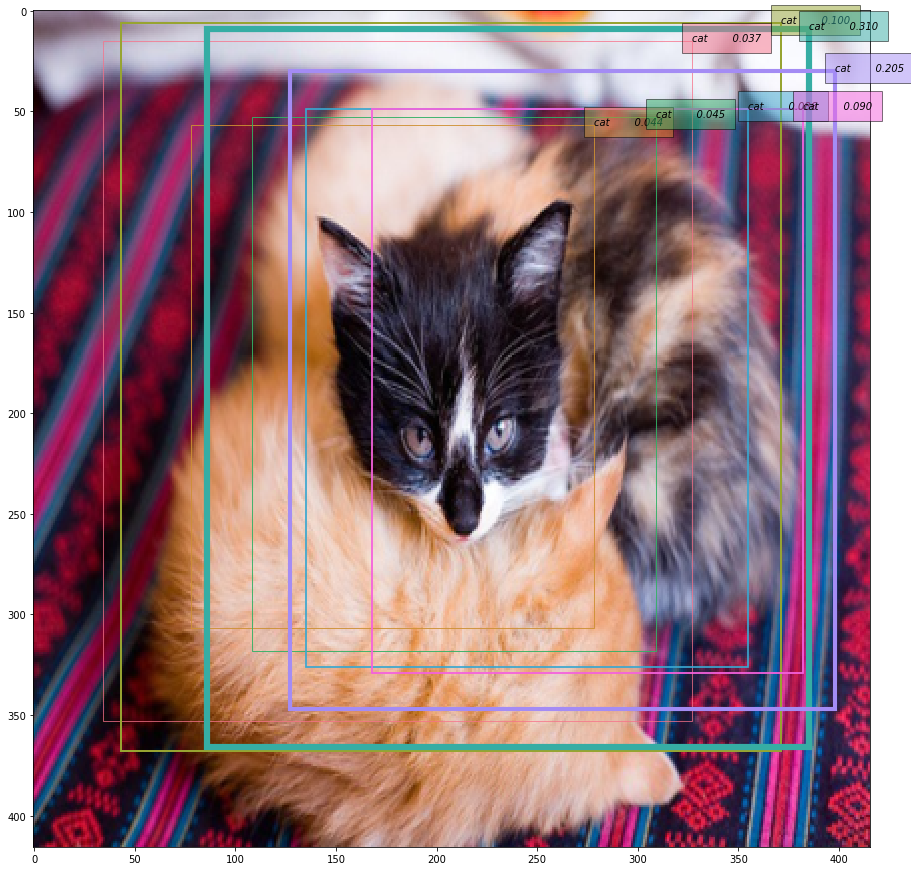

In [81]:
#plot the prediced boxes from ypread on top of the test input Xtest
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.pyplot as plt

def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)
    fig, axis = plt.subplots(1,figsize = (15,20))
    
    axis.imshow(image)
    
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
        
        rect = patches.Rectangle((xmin,ymin),xmax -xmin,ymax -ymin,linewidth=sr,edgecolor=color,facecolor='none')
        axis.add_patch(rect)
       
        text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        axis.text(xmax, ymin, text, style='italic',
        bbox={'facecolor':color, 'alpha':0.5, 'pad':10})
    plt.show()
    

        
    return image


print("Plot with low object threshold")
a = draw_boxes(X_test[0],pred_low_tsh,LABELS,verbose=True)
print("Plot with high object threshold")
b = draw_boxes(X_test[0],pred_high_tsh,LABELS,verbose=True)






In [ ]:
print("Plot with low object threshold")
a = draw_boxes(X_test[0],pred_low_tsh,LABELS,verbose=True)
print("Plot with high object threshold")
b = draw_boxes(X_test[0],pred_high_tsh,LABELS,verbose=True)

